## **Importing libraries**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive, files
import sys
drive.mount('/content/drive/')
sys.path.append('/content/drive/MyDrive/ADS2001 project/')
upload = files.upload()
from logitplots import *

# Sklearn Libraries
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split # import the splitting method from sklearn
from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve, auc, precision_score, accuracy_score, recall_score, classification_report, ConfusionMatrixDisplay
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, Ridge, Lasso
from sklearn.inspection import permutation_importance # Used for seeing the importance of features
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import plot_tree
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

df = pd.read_csv('/content/drive/MyDrive/ADS2001 project/data/virtualInternshipData_modified.csv', encoding = 'ISO-8859-1')
df = df.iloc[:, 1:].rename(columns={"target":"OutcomeScore"})
df['OutcomeScore'] = df['OutcomeScore'].astype(int)

Mounted at /content/drive/


Saving logitplots.py to logitplots.py




---


## **Baseline Model**

We decided to use a very simple model --- kNN as the baseline model . See what the result it is

**Summary:**
- 🎯 Accuracy (Train): 0.644
- 🧪 Accuracy (Test): 0.376
- ⚠️ Imbalance might exist between scores.

Seeing that most of the data are categorical, the only approach that we could use is to have kNN as our baseline model.


In [2]:
def plt_confusion_matrix(cnf_matrix, cats, method):
    """
    Given actual target values and predicted values for a classifier 'method',
    plots the confusion matrix
    """
    # write the confusion matrix to a dataframe with row and column names as the categories
    cmatrix = pd.DataFrame(cnf_matrix,columns=cats,index=cats)
    f, ax = plt.subplots(figsize=(6,6)) # initialise the plots and axes
    sns.heatmap(cmatrix, annot=True, fmt = 'd',linewidths=.5) # plot the confusion matrix as a heatmap
    plt.title('Confusion matrix for '+method) # add a title, + concatenates two strings
    plt.ylabel('Actual label') # add a ylabel
    plt.xlabel('Predicted label') # add a xlabel
    # adjust the bottom and top of the figure, so we can view all of it
    bottom, top = ax.get_ylim()  # get the y axis limits
    ax.set_ylim(bottom + 0.5, top - 0.5); # adjust the y axis limits

In [3]:
evaluate_models = []
def evaluate_model(X, y, X_test, y_test, step_name, model=None):
    """Evaluate and return metrics after each processing step."""
    if model is None:
        model = KNeighborsClassifier(weights='uniform')  # Default model

    model.fit(X, y)
    y_pred = model.predict(X_test)
    report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)

    return {
        'Step': step_name,
        'Train Accuracy': round(model.score(X, y), 4),
        'Test Accuracy': round(model.score(X_test, y_test), 4),
        'Precision': round(report['weighted avg']['precision'], 4),
        'Recall': round(report['weighted avg']['recall'], 4),
        'F1-Score': round(report['weighted avg']['f1-score'], 4)
    }

In [5]:
n_neighbours = 3
X = df.iloc[:, 2:-1]
y = df['OutcomeScore']

In [6]:
X_train,X_test,y_train,y_test=train_test_split(X,y,train_size=0.8,random_state=42)

clf = KNeighborsClassifier(n_neighbours, weights = 'uniform')
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

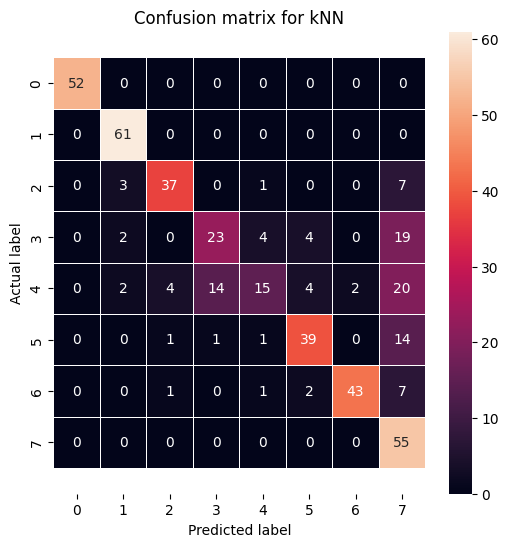

In [7]:
categories = np.unique(np.concatenate((y_test, y_pred)))
cnf_matrix = confusion_matrix(y_test, y_pred, labels = categories) # create a confusion matrix for our actual and predicted values
plt_confusion_matrix(cnf_matrix, categories, 'kNN')

 We can now calculate the accuracy of the model. This is simply the total number of correct predictions, i.e., the sum of the terms on the main diagonal of the confusion matrix, divided by the number of predictions, i.e., the sum of all the terms in the confusion matrix. In this case we have 4+26+18=48 correct predictions, and 133 total predictions. Therefore the accuracy in this case is 0.361. For a very good model the accuracy will approach 1, whereas for a very poor model the accuracy will approach 0.

In [ ]:
evaluate_models.append(evaluate_model(X_train, y_train, X_test, y_test, 'kNN'))

In [ ]:
pd.DataFrame(evaluate_models).set_index('Step')

,Train Accuracy,Test Accuracy,Precision,Recall,F1-Score
Step,,,,,
kNN,0.7633,0.7198,0.7672,0.7198,0.7041




---


## **Predictive Modelling**

### **Support Vector Machine**

In [ ]:
X = df.iloc[:, 2:-1]  # Dropping multiple columns
y = df['OutcomeScore']  # Outcome scores as target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:

# Define hyperparameter combinations
params = [
    {'kernel': 'linear', 'C': 0.1, 'gamma': 'auto', 'decision_function_shape': 'ovr'},
    {'kernel': 'linear', 'C': 1, 'gamma': 'auto', 'decision_function_shape': 'ovr'},
    {'kernel': 'linear', 'C': 10, 'gamma': 'auto', 'decision_function_shape': 'ovo'},
    {'kernel': 'rbf', 'C': 1, 'gamma': 0.01, 'decision_function_shape': 'ovr'},
    {'kernel': 'rbf', 'C': 10, 'gamma': 0.001, 'decision_function_shape': 'ovo'},
    {'kernel': 'rbf', 'C': 100, 'gamma': 0.0001, 'decision_function_shape': 'ovr'},
    {'kernel': 'poly', 'C': 1, 'gamma': 'scale', 'decision_function_shape': 'ovo'},
    {'kernel': 'poly', 'C': 5, 'gamma': 0.1, 'decision_function_shape': 'ovr'},
    {'kernel': 'sigmoid', 'C': 1, 'gamma': 0.01, 'decision_function_shape': 'ovr'}
]

results = []

# Loop through each combination
for p in params:
    model = SVC(
        kernel=p['kernel'],
        C=p['C'],
        gamma=p['gamma'],
        decision_function_shape=p['decision_function_shape']
    )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)

    results.append({
        'Kernel': p['kernel'],
        'C': p['C'],
        'Gamma': p['gamma'],
        'Decision Function': p['decision_function_shape'],
        'Accuracy': round(acc, 4)
    })

# Create DataFrame of results
results_df = pd.DataFrame(results).sort_values(by=['Accuracy'], ascending = False)
results_df
# Display the DataFrame
#import ace_tools as tools; tools.display_dataframe_to_user(name="SVM Hyperparameter Results", dataframe=results_df)



,Kernel,C,Gamma,Decision Function,Accuracy
7,poly,5.0,0.1,ovr,0.7130
2,linear,10.0,auto,ovo,0.6948
1,linear,1.0,auto,ovr,0.6948
0,linear,0.1,auto,ovr,0.6811
4,rbf,10.0,0.001,ovo,0.6765
5,rbf,100.0,0.0001,ovr,0.6743
3,rbf,1.0,0.01,ovr,0.6720
8,sigmoid,1.0,0.01,ovr,0.6059
6,poly,1.0,scale,ovo,0.4487


In [ ]:
top3 = results_df.sort_values(by='Accuracy', ascending=False).head(3)
for idx, row in top3.iterrows():
    model = SVC(kernel=row['Kernel'], C=row['C'],  gamma=row['Gamma'], decision_function_shape=row['Decision Function'], random_state=42)
    evaluate_models.append(evaluate_model(X_train, y_train, X_test, y_test, f"SVM {row['Kernel']} C = {row['C']}", model=model))

pd.DataFrame(evaluate_models).set_index('Step')

,Train Accuracy,Test Accuracy,Precision,Recall,F1-Score
Step,,,,,
kNN,0.7633,0.7198,0.7672,0.7198,0.7041
SVM poly C = 5.0,0.7735,0.7130,0.7795,0.7130,0.7096
SVM linear C = 10.0,0.7353,0.6948,0.7353,0.6948,0.6874
SVM linear C = 1.0,0.7307,0.6948,0.7386,0.6948,0.6885


### **Decision Tree**

In [ ]:
# 1. Baseline Decision Tree
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Baseline model
dt_baseline = DecisionTreeClassifier(random_state=42)

# Evaluate baseline
evaluate_models.append(evaluate_model(X_train, y_train, X_test, y_test, f"Decision Tree Baseline", model=dt_baseline))
pd.DataFrame(evaluate_models).set_index('Step')

,Train Accuracy,Test Accuracy,Precision,Recall,F1-Score
Step,,,,,
kNN,0.7633,0.7198,0.7672,0.7198,0.7041
Decision Tree Baseline,0.8614,0.7130,0.7530,0.7130,0.7058


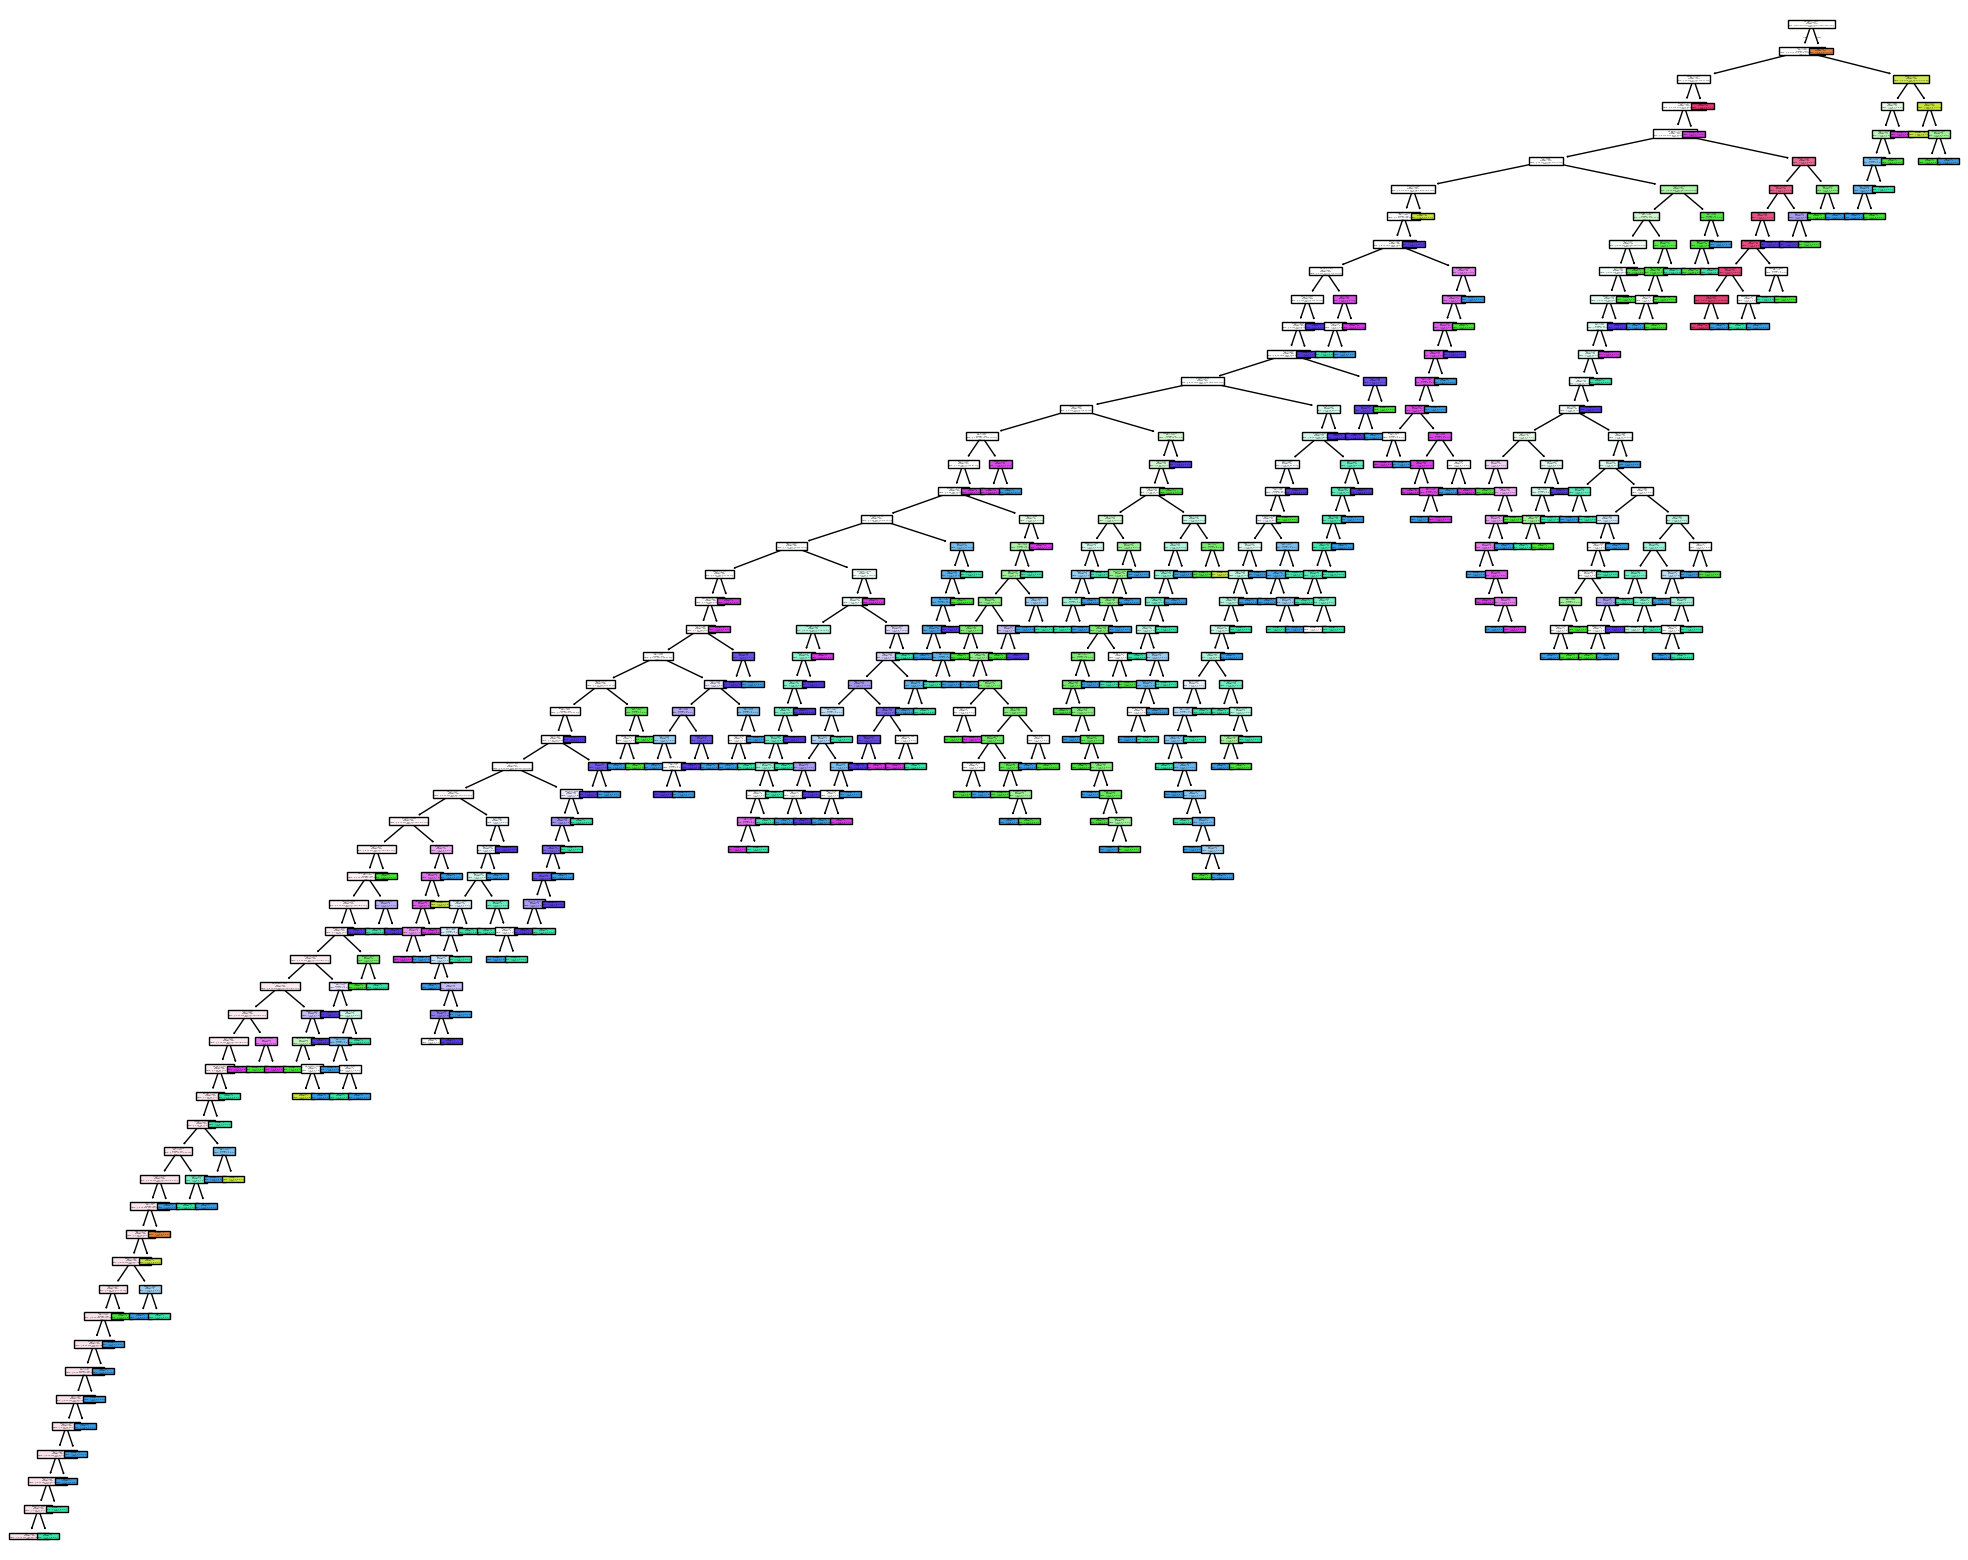

In [ ]:
# Plot of Baseline DT
fig = plt.figure(figsize=(25,20))
dt_baseline_plot = tree.plot_tree(dt_baseline,
                   feature_names=X.columns,
                   class_names=[str(c) for c in y.unique()],
                   filled=True)

In [ ]:
from sklearn.model_selection import GridSearchCV
# Hyperparameter Tuning
param_grid = {'max_depth': [5, 10, 15, 25, 30, 50], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'criterion': ['gini', 'entropy']}

dt_tuned = GridSearchCV(
    DecisionTreeClassifier(random_state=42),
    param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)
dt_tuned.fit(X_train, y_train)
print("\nBest Parameters:", dt_tuned.best_params_)


Best Parameters: {'criterion': 'entropy', 'max_depth': 50, 'min_samples_leaf': 1, 'min_samples_split': 2}


In [ ]:
# Evaluate Best Model
tuned_model = DecisionTreeClassifier(
    max_depth=dt_tuned.best_params_['max_depth'],
    min_samples_split=dt_tuned.best_params_['min_samples_split'],
    min_samples_leaf=dt_tuned.best_params_['min_samples_leaf'],
    criterion=dt_tuned.best_params_['criterion'],
    random_state=42
)
evaluate_models.append(evaluate_model(X_train, y_train, X_test, y_test, f"Decision Tree Max Depth = {dt_tuned.best_params_['criterion']}, Min Samples Split = {dt_tuned.best_params_['min_samples_leaf']}", model=tuned_model))
pd.DataFrame(evaluate_models).set_index('Step')

,Train Accuracy,Test Accuracy,Precision,Recall,F1-Score
Step,,,,,
kNN,0.7633,0.7198,0.7672,0.7198,0.7041
Decision Tree Baseline,0.8614,0.7130,0.7530,0.7130,0.7058
"Decision Tree Max Depth = entropy, Min Samples Split = 1",0.8614,0.7016,0.7353,0.7016,0.6904


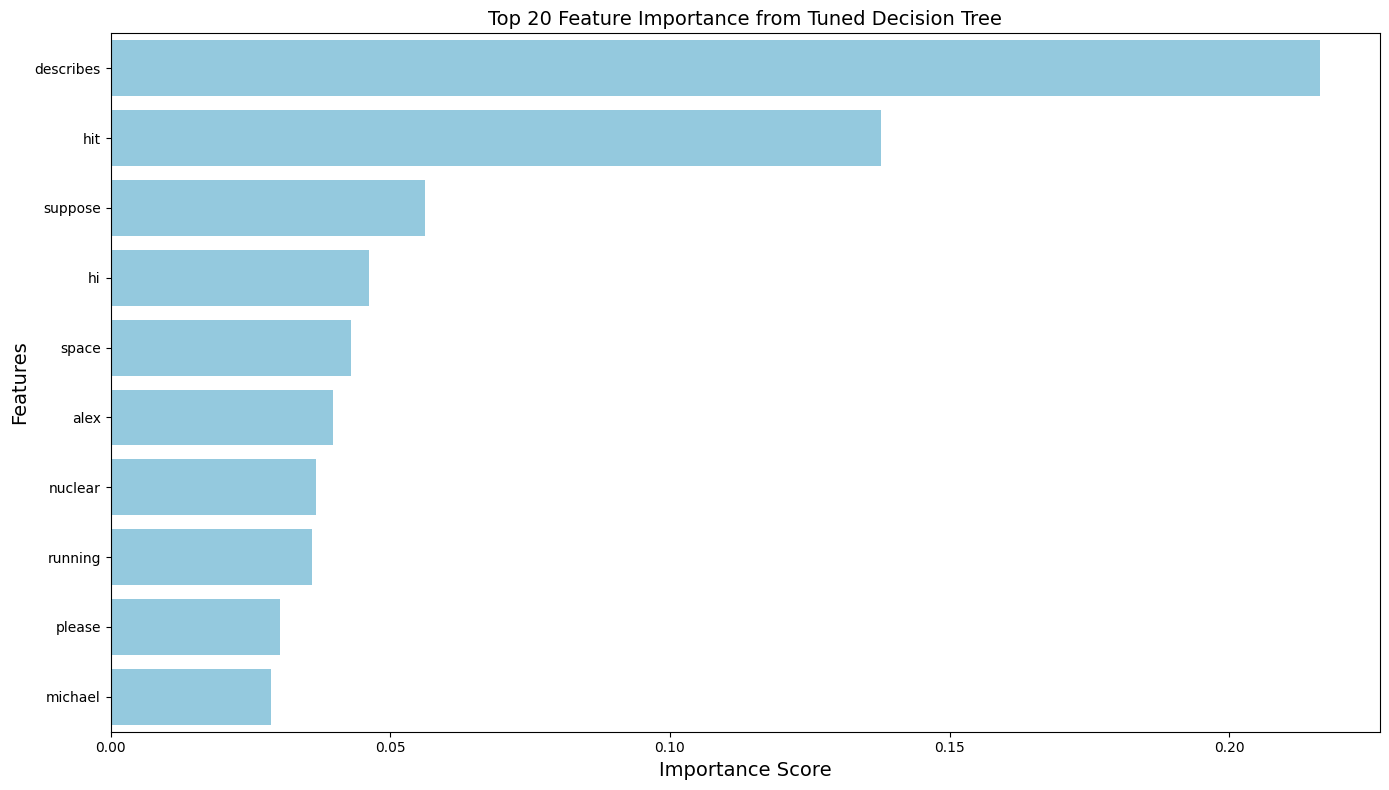

In [ ]:
# Fit the tuned model
tuned_model.fit(X_train, y_train)  # Make sure you've fitted the model first

# Get feature importances
importances = tuned_model.feature_importances_
feature_names = X_train.columns  # Assuming X_train is a pandas DataFrame

# Create a DataFrame for visualization
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values('Importance', ascending=False).head(10)

# Plotting
plt.figure(figsize=(14, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, color = '#87CEEB')
plt.title('Top 20 Feature Importance from Tuned Decision Tree', fontsize=14)
plt.xlabel('Importance Score', fontsize=14)
plt.ylabel('Features', fontsize=14)
plt.tight_layout()
plt.show()

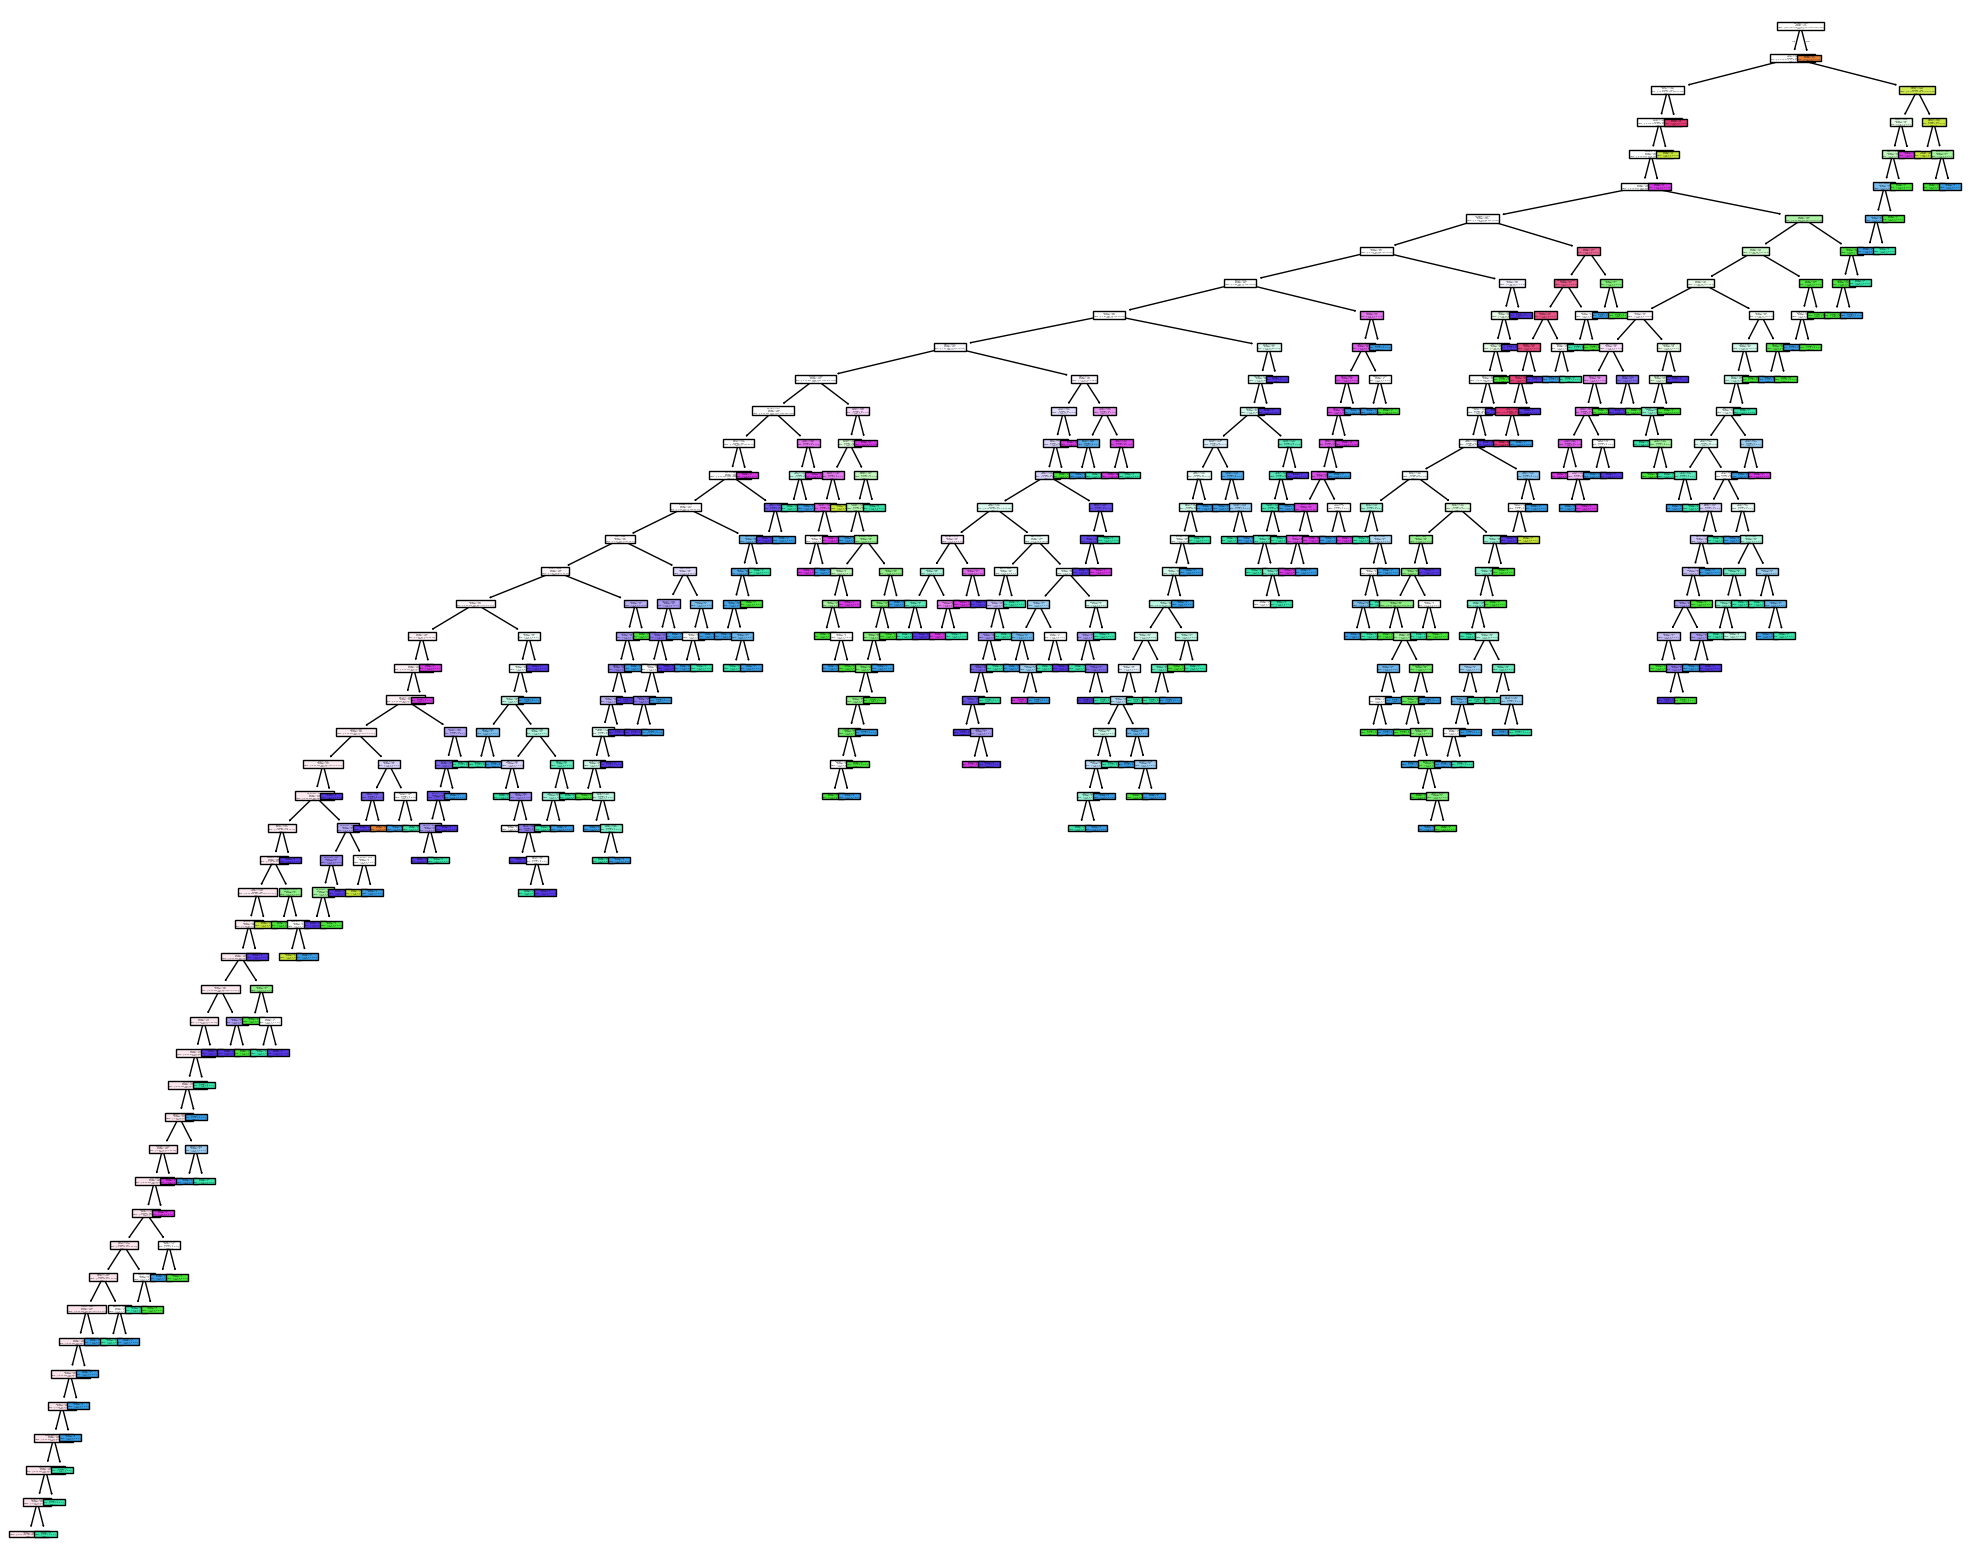

In [ ]:
# Plot of Tuned DT
fig = plt.figure(figsize=(25,20))
dt_tuned_plot = tree.plot_tree(tuned_model,
                   feature_names=X.columns,
                   class_names=[str(c) for c in y.unique()],
                   filled=True)

In [ ]:
df.head(3)

,groupIDs,roomName,150,318,53,added,advise,aid,alex,ali,...,trust,tuck,tyler,unachievable,user,utilize,white,world,yas,OutcomeScore
0,2a,Background research on dialysis,-0.058674,-0.041065,-0.041065,-0.057644,-0.041065,-0.067859,-0.236912,-0.074937,...,-0.056875,-0.06913,-0.112878,-0.041065,-0.076842,-0.106252,-0.058087,-0.112572,-0.057933,5
1,2a,Choose consultants to analyze,-0.058674,-0.041065,-0.041065,-0.057644,-0.041065,-0.067859,-0.236912,-0.074937,...,-0.056875,-0.06913,-0.112878,-0.041065,-0.076842,-0.106252,-0.058087,-0.112572,-0.057933,4
2,2a,Individual analysis of first batch,-0.058674,-0.041065,-0.041065,-0.057644,-0.041065,-0.067859,-0.236912,-0.074937,...,-0.056875,-0.06913,-0.112878,-0.041065,-0.076842,-0.106252,-0.058087,-0.112572,-0.057933,3


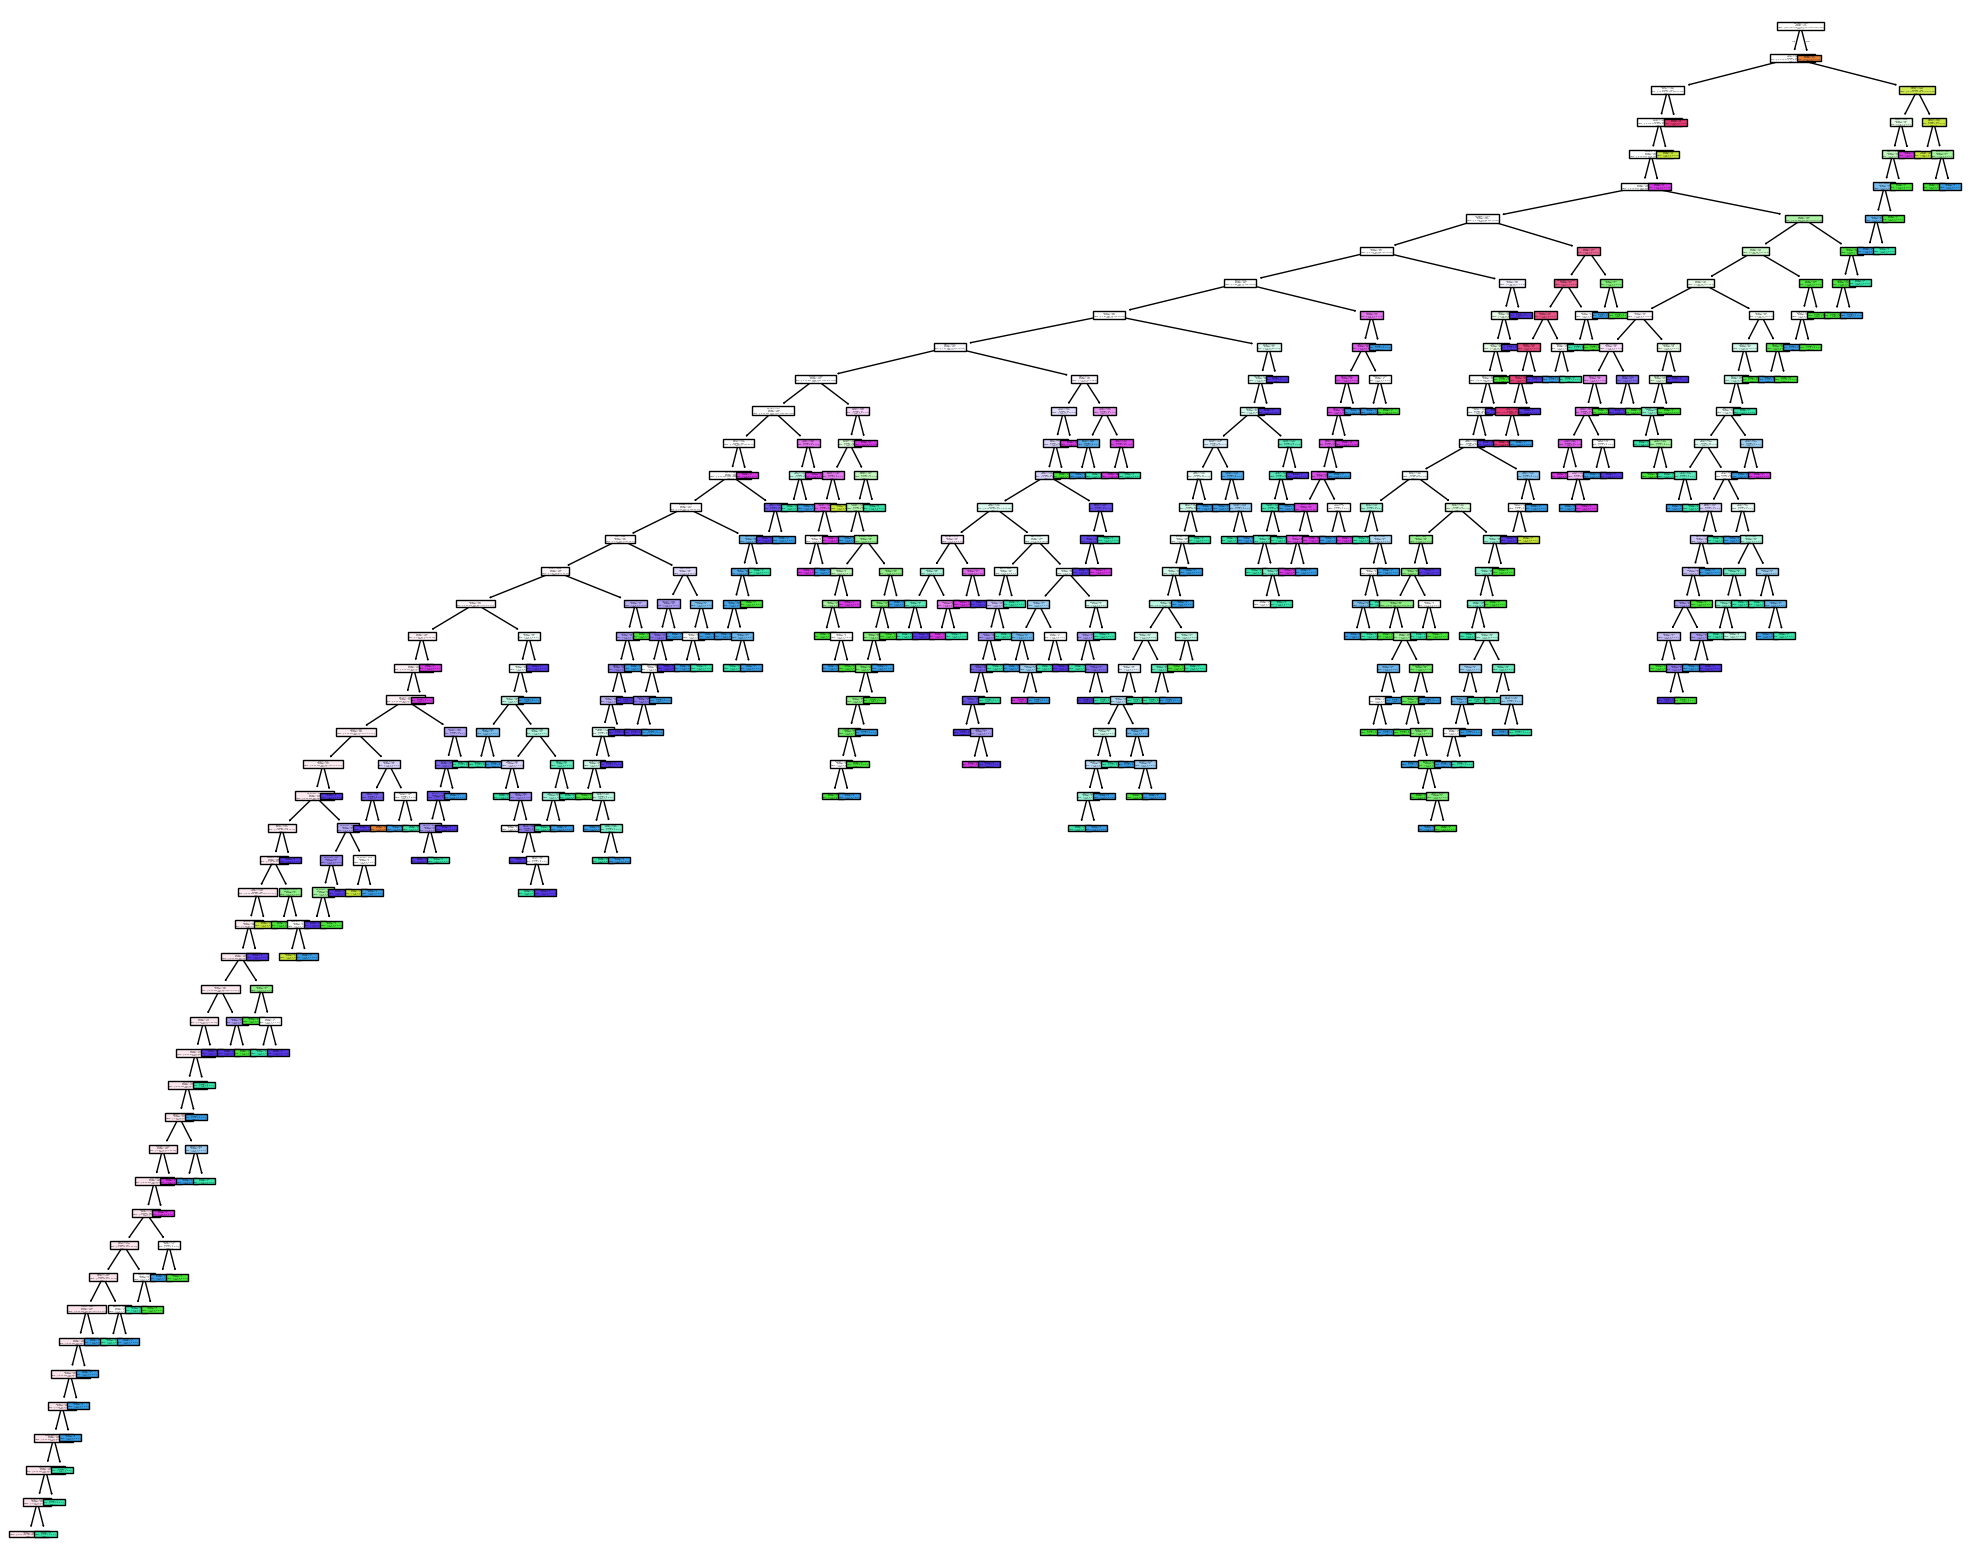

In [ ]:

# Plotting the Decision Tree graph

fig = plt.figure(figsize=(25,20))
dt_tuned_plot = tree.plot_tree(tuned_model,
                   feature_names=X.columns,
                   class_names=[str(c) for c in y.unique()],
                   filled=True)

### **Random Forest**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Baseline model
rf_baseline = RandomForestClassifier(random_state=42)

evaluate_models.append(evaluate_model(X_train, y_train, X_test, y_test, f"Random Forest Baseline", model=rf_baseline))
pd.DataFrame(evaluate_models).set_index('Step')

,Train Accuracy,Test Accuracy,Precision,Recall,F1-Score
Step,,,,,
kNN,0.7633,0.7198,0.7672,0.7198,0.7041
Decision Tree Baseline,0.8614,0.7130,0.7530,0.7130,0.7058
"Decision Tree Max Depth = entropy, Min Samples Split = 1",0.8614,0.7016,0.7353,0.7016,0.6904
Random Forest Baseline,0.8614,0.7540,0.7999,0.7540,0.7511


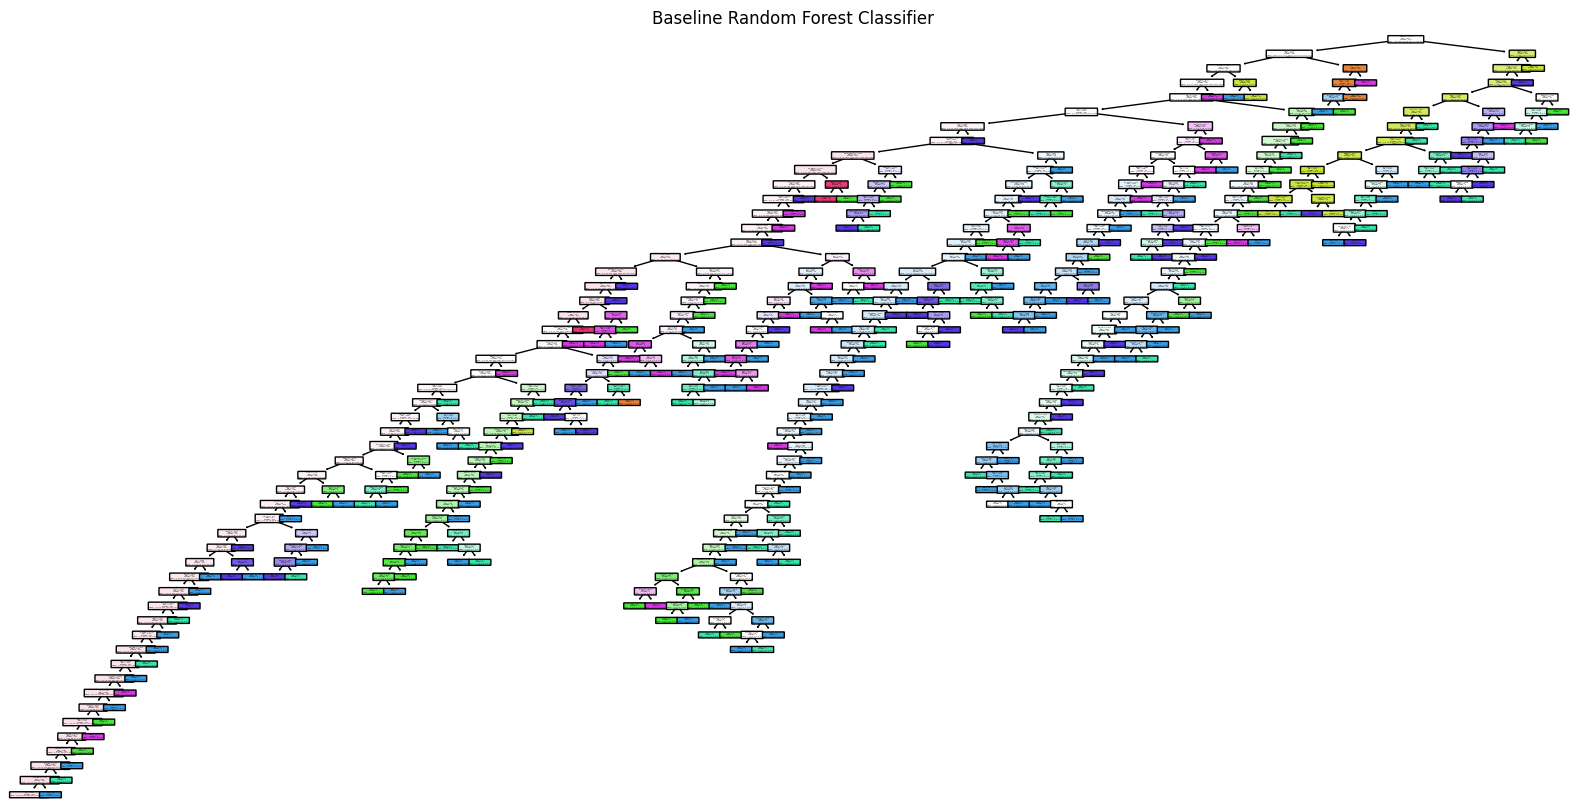

In [ ]:
# Plotting the baseline RandomForest graph
rf_baseline_plot = rf_baseline.estimators_[0]
plt.figure(figsize=(20,10))
plot_tree(tree,
          feature_names=X.columns,
          class_names=[str(c) for c in y.unique()],
          filled=True,
          rounded=True)
plt.title("Baseline Random Forest Classifier")
plt.show()

In [ ]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2', 'auto']
}

rf_tuned = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)
rf_tuned.fit(X_train, y_train)

# Best parameters
print("\nBest Parameters:", rf_tuned.best_params_)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
180 fits failed out of a total of 540.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
180 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 1382, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.11/dist-packages/sklearn/util


Best Parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}


In [ ]:
# Evaluate Best Model
tuned_model = RandomForestClassifier(
    **rf_tuned.best_params_,
    random_state=42
)
evaluate_models.append(evaluate_model(X_train, y_train, X_test, y_test, f"Random Forest Max Depth = {rf_tuned.best_params_['n_estimators']}, Min Samples Split = {rf_tuned.best_params_['min_samples_split']}, n_estimators = {rf_tuned.best_params_['n_estimators']}, max_features = {rf_tuned.best_params_['max_features']}", model=tuned_model))
pd.DataFrame(evaluate_models).set_index('Step')

,Train Accuracy,Test Accuracy,Precision,Recall,F1-Score
Step,,,,,
kNN,0.7633,0.7198,0.7672,0.7198,0.7041
Decision Tree Baseline,0.8614,0.7130,0.7530,0.7130,0.7058
"Decision Tree Max Depth = entropy, Min Samples Split = 1",0.8614,0.7016,0.7353,0.7016,0.6904
Random Forest Baseline,0.8614,0.7540,0.7999,0.7540,0.7511
"Random Forest Max Depth = 200, Min Samples Split = 5, n_estimators = 200, max_features = sqrt",0.8505,0.7585,0.8082,0.7585,0.7578


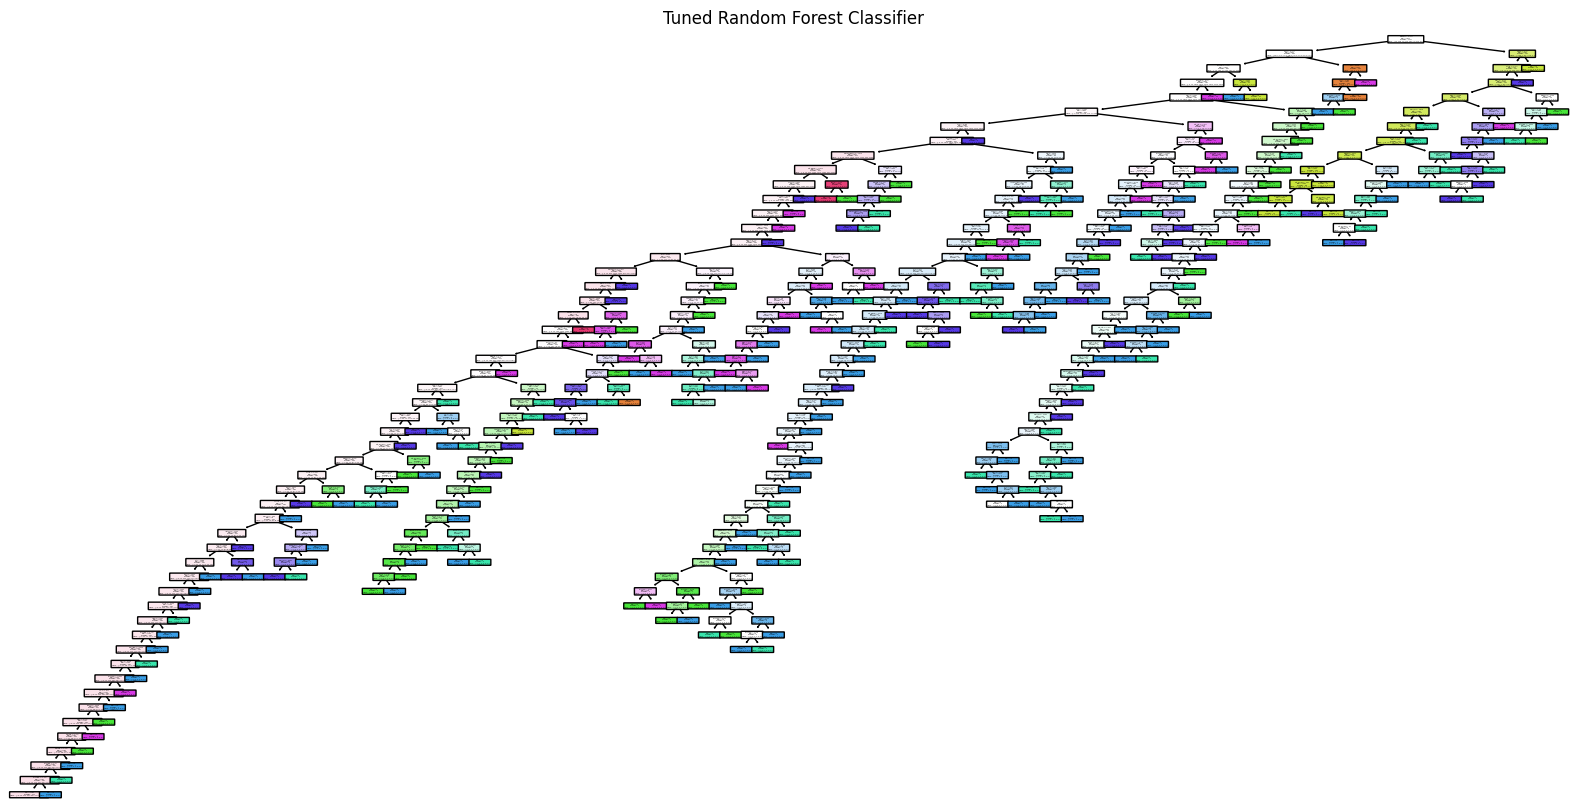

In [ ]:
# Plotting the Tuned Random Forest Classifier
rf_tuned_plot = tuned_model.estimators_[0]
plt.figure(figsize=(20,10))
plot_tree(tree,
          feature_names=X.columns,
          class_names=[str(c) for c in y.unique()],
          filled=True,
          rounded=True)
plt.title("Tuned Random Forest Classifier")
plt.show()

### **Gradient Boosting**

In [10]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV

# Baseline model
gb_baseline = GradientBoostingClassifier(random_state=42)

evaluate_models.append(evaluate_model(X_train, y_train, X_test, y_test, f"Gradient Boosting Baseline", model=gb_baseline))
pd.DataFrame(evaluate_models).set_index('Step')

,Train Accuracy,Test Accuracy,Precision,Recall,F1-Score
Step,,,,,
Gradient Boosting Baseline,0.8083,0.7084,0.748,0.7084,0.6994
Gradient Boosting Baseline,0.8083,0.7084,0.748,0.7084,0.6994


In [ ]:
# Hyperparameter tuning
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.5],
    'max_depth': [3, 5, 7],
    'min_samples_leaf': [1, 2, 4]
}

gb_tuned = GridSearchCV(
    GradientBoostingClassifier(random_state=42),
    param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)
gb_tuned.fit(X_train, y_train)

# Best model
print("Best params:", gb_tuned.best_params_)

Best params: {'learning_rate': 0.1, 'max_depth': 3, 'min_samples_leaf': 2, 'n_estimators': 200}


In [ ]:
gb_tuned_model = GradientBoostingClassifier(**gb_tuned.best_params_, random_state=42)
evaluate_models.append(evaluate_model(X_train, y_train, X_test, y_test, f"Gradient Boosting Max Depth = {gb_tuned.best_params_['max_depth']}, Learning Rate = {gb_tuned.best_params_['learning_rate']}, n_estimators = {gb.tuned.best_params_['n_estimators']}", model=gb_tuned_model))
pd.DataFrame(evaluate_models).set_index('Step')

NameError: name 'gb' is not defined

### **AdaBoost**

### **XGBoost**

### **LightGBM**

In [ ]:
from lightgbm import LGBMClassifier

lgbm = LGBMClassifier(random_state=42)
evaluate_models.append(evaluate_model(X_train, y_train, X_test, y_test, f"LightGBM", model=lgbm))
pd.DataFrame(evaluate_models).set_index('Step')

### **Logistic Regression**

- The AUC value is the highest for class 0, and lowest for class 1
- This is suggesting that the model is excellent at predicting the outcome score being 0, but poorest at score being 1.
<br>

Trainning Score: 1
<br>
Testing Score: 0.361
<br>
This is suggesting that the model has a serious problem of overfitting.

In [ ]:
# Defining some functions
# Binarize the output for multiclass
def plot_roc_auc_multinomial(X_test, y_test, model):
    classes = np.unique(y_test)
    y_test_bin = label_binarize(y_test, classes=classes)
    y_pred_proba = model.predict_proba(X_test)

    # Plot ROC for each class
    for i in range(len(classes)):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"Class {classes[i]} (AUC = {roc_auc:.3f})")

    # Plot diagonal and perfect classifier for reference
    plt.plot([0, 1], [0, 1], 'k--', label='Random')
    plt.plot([0, 0, 1], [0, 1, 1], 'g--', label="'Perfect' Classifier")

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Multiclass ROC Curve')
    plt.legend(loc='best')
    plt.show()

# Plotting confusion matrix
def plot_cnf_matrix(df, y_test, y_pred):
    cnf_matrix = confusion_matrix(y_test, y_pred)
    class_names=y_test.unique()
    cmatrix = pd.DataFrame(cnf_matrix,columns=class_names,index=class_names)
    f, ax = plt.subplots(figsize=(7,6))
    sns.heatmap(cmatrix, annot=True, fmt='d', cmap='rocket',
                xticklabels=class_names, yticklabels=class_names,
                linewidths=0.5, linecolor='gray', cbar=True)
    plt.title('Confusion matrix')
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)



# Dropping all the unnecessary columns

X = df.iloc[:, 3:-1]
y = df['OutcomeScore']



# Normalization
scaler = StandardScaler()
Xn = scaler.fit_transform(X)


# Spliting Train/Testing sets
X_train, X_test, y_train, y_test = train_test_split(Xn, y, test_size=0.2,random_state=42)


LogisticModel = LogisticRegression().fit(X_train, y_train)
y_pred = LogisticModel.predict(X_test)

# Getting Scores
precision = precision_score(y_test, y_pred, average='macro')
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred, average='macro')



# Plot ROC and confusion matrix
plot_roc_auc_multinomial(X_test, y_test, LogisticModel)



In [ ]:
plot_cnf_matrix(df, y_test, y_pred)

In [ ]:
print("Accuracy (Train):",np.round(LogisticModel.score(X_train, y_train),3))
print("Accuracy (Test):",np.round(LogisticModel.score(X_test, y_test),3))

In [ ]:
evaluate_models.append(evaluate_model(X_train, y_train, X_test, y_test, f"Logistic Model Baseline", model=LogisticModel))
pd.DataFrame(evaluate_models).set_index('Step')

#### Hyperparametre Tuning
Because the model is not performing so well (we see that it is overfitting), therefore I will do some hyperparametre tuning to find the parametres that is most suitable for the model

** NOTE ** The code below runs for at least 20 min, so if you want to run it please be patient.

In [ ]:

from sklearn.model_selection import GridSearchCV


# Because each penalty can only be used on a certain solver, therfore we create a list of
# dictionary which contains the suitable solver for each penalty

# These were found on https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
param_grids = [
    # l1 penalty -> only 'liblinear' and 'saga'
    {
        'penalty': ['l1'],
        'solver': ['liblinear', 'saga'],
        'C': [0.01, 0.1, 1, 10]
    },
    # l2 penalty -> several solvers
    {
        'penalty': ['l2'],
        'solver': ['newton-cg', 'sag', 'lbfgs', 'liblinear', 'saga'],
        'C': [0.01, 0.1, 1, 10]
    },
    # elasticnet penalty -> only 'saga'
    {
        'penalty': ['elasticnet'],
        'solver': ['saga'],
        'C': [0.01, 0.1, 1, 10],
        'l1_ratio': [0.3, 0.5, 0.7]
    },
    # no penalty -> no regularization
    {
        'penalty': ['none'],
        'solver': ['newton-cg', 'lbfgs', 'sag', 'saga']
    }
]

estimator_ = LogisticRegression(max_iter=1000)

# Using GridSearchCV
grid_search = GridSearchCV(estimator=estimator_,
                          param_grid=param_grids,
                          scoring='accuracy',
                          cv=5,
                          n_jobs=-1,
                          verbose=1)

grid_search.fit(X_train, y_train)



In [ ]:
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

best_model_test = best_model.score(X_test, y_test)
best_model_train = best_model.score(X_train, y_train)

best_model_pred = best_model.predict(X_test)

print('Best Parametres: ', best_params)
print('Best model: ', best_model)
print('Model testing score: ', best_model_test)
print('Model training score: ', best_model_train)

# Also plotting the confusion matrx/Roc_auc_curve
plot_roc_auc_multinomial(X_test, y_test, best_model)
plot_cnf_matrix(df, y_test, best_model_pred)

In [ ]:
evaluate_models.append(evaluate_model(X_train, y_train, X_test, y_test, f"Logistic Model Hyperparameter Tuned", model=best_model))
pd.DataFrame(evaluate_models).set_index('Step')

### **Final Evaluation**